# NoisePy4DAS: SeaDAS-N as an example

- Yiyu Ni (niyiyu@uw.edu)
- Department of Earth and Space Sciences, University of Washington

- Project URL: 
    - https://github.com/niyiyu/DASstore
    - https://github.com/chengxinjiang/NoisePy_4DAS
    - https://github.com/niyiyu/NoisePy4DAS-SeaDAS
    
- SCEC Cyber Training for Seismology (May 9 - 12, 2023) 
    - https://seisscoped.org/HPS/
    
- More about SeaDAS-N experiment at Photonic Sensing Facility (PSF)
  - https://psf.uw.edu (Lead PI: Brad Lipovsky)
    
- Last updated: May 8, 2023

#### SeaDAS-N
(a) Map showing the location of the SeaDAS-N cable (solid line) connecting Seattle and Bothell campus of the University of Washington in Seattle, Washington, United States. Only the red segment was used during December 2022 for data collection. (b) One-hour SeaDAS-N raw data (in radians) of all 2089 channels. The Sintela Onyx interrogator unit samples at 100 Hz, with 4.78-meter channel spacing and 9.56-meter gauge length. The example plot starts 2022-12-15 13:30:00 UTC. The gray region indicates a one-minute data gap. The clipped sub-array (channel $\sim$1100-1700) is from the segment where the cable is above the ground.

![title](https://github.com/niyiyu/NoisePy4DAS-SeaDAS/blob/main/figures/seadas_december_overview.png?raw=true)

# Only run one based on your environment
**If you run this tutorial on google colab, install required packages using the code cell below**

⚠️ You would need to restart the run time to make ObsPy running properly.

In [ ]:
# may take ~1 minute to install
# !pip install obspy scipy h5py numpy tiledb==0.19.0 s3fs fsspec matplotlib zarr tqdm pyasdf
# !git clone https://github.com/niyiyu/NoisePy4DAS-SeaDAS

In [1]:
# on colab
import sys
sys.path.append("./NoisePy4DAS-SeaDAS/src")
sys.path.append("./NoisePy4DAS-SeaDAS/DASstore")

**If you run the tutorial through docker, or if you clone the repo, run the cell below**

In [2]:
# on Docker/local
import sys
sys.path.append("../src")
sys.path.append("../DASstore") 

## 0 import necessary packages

In [3]:
import os
import time
from datetime import datetime, timedelta

import h5py
import numpy as np
import DAS_module
import matplotlib.pyplot as plt
from tqdm import tqdm

from dasstore.zarr import Client

## 1 connect to the DAS data client

We store the DAS data in the Zarr format on an object storage machine at University of Washington (endpoint [`http://dasway.ess.washington.edu`](http://dasway.ess.washington.edu/)). The data can be downloaded through a `DASstore.zarr.Client`. Another copy of this data is available on AWS S3 (`s3://seadas-december-2022` in `us-west-2` region). Both copies allow public access during the workshop so that you can download the data without any access key. 

⚠️If you see `ACCESS DENY` error in the following block, it may due to a temporarily access policy change. You could try later if during the workshop, or reach out to the team if after the workshop (if you are interested in using the SeaDAS data). 

In [4]:
# client arguments for DASway.ess.washington.edu
# (server in UW ESS)
bucket = "seadas-december-2022"
endpoint = "dasway.ess.washington.edu"
secure = True   # HTTPs

# prepare client
client = Client(bucket, endpoint, secure = secure, anon = True)
client

Endpoint:  	 https://dasway.ess.washington.edu
Path:    	 s3://seadas-december-2022 
Anonymous: 	 True 
Backend:   	 Zarr


⚠️**egress cost applied**

In [10]:
# # client arguments for AWS S3
# # (AWS S3 server)
# bucket = "seadas-december-2022"
# endpoint = "s3.us-west-2.amazonaws.com"
# secure = True   # HTTPs

# # prepare client
# client = Client(bucket, endpoint, secure = secure, anon = True)
# client

### metadata
show acquisiton start and end time

In [5]:
print(f"acquisition starts at {client.meta['acquisition.acquisition_start_time']}")
print(f"acquisition ends at {client.meta['acquisition.acquisition_end_time']}")

acquisition starts at 2022-12-01T00:00:00.000000
acquisition ends at 2022-12-31T23:59:59.990000


`client.get_metadata()` function provides more information about this DAS data. we focus on the convention proposed by the DAS Research Coordination Network (RCN, https://www.iris.edu/hq/initiatives/das_rcn), which was a NSF-supported community effort to define common metadata for DAS. As of May 2023, the DAS-RCN defined five levels of metadata describing an experiment under this convention: Overview, Cable, Fiber, Interrogator, and Acquisition. These metadata are saved with the raw data supported by Zarr and TileDB formats as key-value-pair attributes. Additional, channel-specific information (channel number, location, and uncertainty) is proposed by the DAS-RCN to be saved in a separate comma-separated values (CSV) file, which is yet included here.

In [6]:
metadata = client.get_metadata()
client.get_metadata()

{'_ARRAY_DIMENSIONS': ['channel', 'time'],
 'acquisition.acquisition_end_time': '2022-12-31T23:59:59.990000',
 'acquisition.acquisition_id': 'N/A',
 'acquisition.acquisition_sample_rate': 100,
 'acquisition.acquisition_start_time': '2022-12-01T00:00:00.000000',
 'acquisition.archived_sample_rate': 'N/A',
 'acquisition.channel_spacing': '4.78 [m]',
 'acquisition.comment': 'N/A',
 'acquisition.decimation': 'N/A',
 'acquisition.filtering': 'N/A',
 'acquisition.gauge_length': '9.56 [m]',
 'acquisition.interrogator_rate': 'N/A',
 'acquisition.number_of_channels': '2089',
 'acquisition.pulse_repetition_rate': 'N/A',
 'acquisition.pulse_width': 'N/A',
 'acquisition.unit_of_measure': 'N/A',
 'cable_and_fiber.attenuation': 'N/A',
 'cable_and_fiber.cable_characteristics': 'N/A',
 'cable_and_fiber.cable_connector_coordinates': 'N/A',
 'cable_and_fiber.cable_coordinates': 'N/A',
 'cable_and_fiber.cable_diameter': 'N/A',
 'cable_and_fiber.cable_end_time': 'N/A',
 'cable_and_fiber.cable_environment'

In [7]:
cha_spacing = float(metadata['acquisition.channel_spacing'].split(' ')[0])
gauge_length = float(metadata['acquisition.gauge_length'].split(' ')[0])
nchas = int(metadata['acquisition.number_of_channels'].split(' ')[0])
print(f"number of channels: {nchas}")
print(f"channel spacing: {cha_spacing} meter")
print(f"guage length: {gauge_length} meter")

number of channels: 2089
channel spacing: 4.78 meter
guage length: 9.56 meter


## 2 download data

For SeaDAS-N data with 2089 channels sampled at 100 Hz, one minute of data is ~40 MB in raw HDF5 format. Ten minute ~400 MB. One hour is about ~2.4 GB.

### DASstore `client.get_data` function
DAS data is, by nature, a 2D array with a time dimension (as the sampling rate of the interrogator) and a channel dimension (effectively space). So when requesting the DAS data, one would need to specify the channel range and the time range. Thus, **three paramemeters are required for the get_data function**.
- `channels`: channel index as numpy array, or list
- `starttime`: start time in string format (UTC)
- `endtime`: end time in string format (UTC)

In [8]:
t0 = time.time()
cha1, cha2 = 500, 1000
alldata = client.get_data(channels = np.arange(cha1, cha2), 
                          starttime = "2022-12-15T13:30:00.000", 
                          endtime   = "2022-12-15T13:31:00.000")
print(f"data is of shape {alldata.shape}")
t1 = time.time()
print(f"it takes %.3f seconds to download data" % (t1 - t0))

data is of shape (500, 6000)
it takes 0.330 seconds to download data


Also note that the data is loaded directly into RAM so that no local storage is needed.

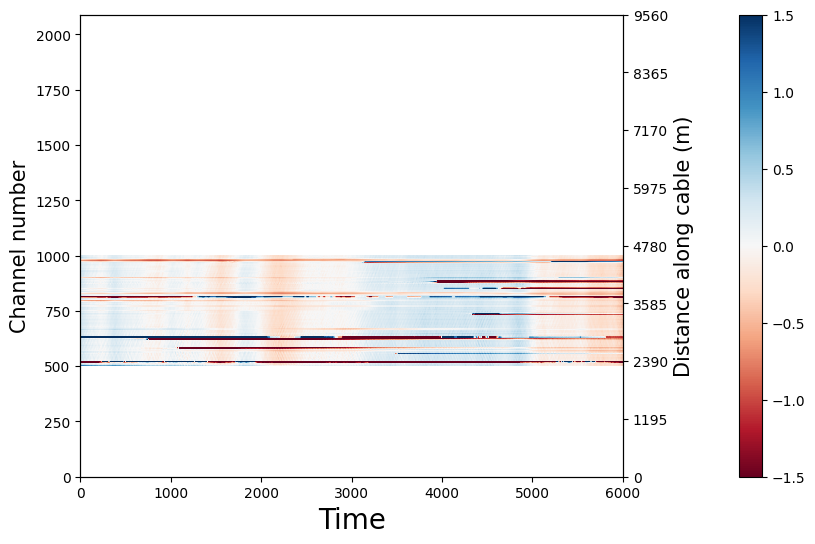

In [9]:
plt.figure(figsize = (10, 6), dpi = 100)
plt.imshow(alldata, aspect = 'auto', extent = [0, 6000, cha1, cha2],
           cmap = 'RdBu', vmax = 1.5, vmin = -1.5, origin='lower')
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 20)
plt.ylim([0, 2089])
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, 2000, 9), 
                [int(i* cha_spacing) for i in np.linspace(0, 2000, 9)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.15)

## 3 cross-correlate with NoisePy4DAS
### 3.1 parameters

In [10]:
sps       = 100                 # current sampling rate
samp_freq = 50                  # targeted sampling rate
freqmin   = 1                   # pre filtering frequency bandwidth
freqmax   = 49.9                  # note this cannot exceed Nquist freq

freq_norm   = 'rma'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'           # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 100               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 100            # moving window length to smooth spectrum amplitude (points)
maxlag      = 8                 # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 10               # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

cc_len = 60                     # correlate length in second
step   = 60                     # stepping length in second

# start and end channel index for the sub-array
cha1, cha2 = 500, 1000

cha_list = np.array(range(cha1, cha2)) 
nsta = len(cha_list)
n_pair = int((nsta+1)*nsta/2)
n_lag = maxlag * samp_freq * 2 + 1

prepro_para = {'freqmin':freqmin,
               'freqmax':freqmax,
               'sps':sps,
               'npts_chunk':cc_len*sps,
               'nsta':nsta,
               'cha_list':cha_list,
               'samp_freq':samp_freq,
               'freq_norm':freq_norm,
               'time_norm':time_norm,
               'cc_method':cc_method,
               'smooth_N':smooth_N,
               'smoothspect_N':smoothspect_N,
               'maxlag':maxlag,
               'max_over_std':max_over_std}

# # you can save this parameter file to local
# metadata = os.path.join(CCFDIR, 'prepro_fft_info.txt')
# # output parameter info
# fout = open(metadata,'w')
# fout.write(str(prepro_para));fout.close()

### 3.2 get data

In [11]:
# get data
minute_data = client.get_data(cha_list, 
                       starttime = "2022-12-01T00:00:00",
                       endtime = "2022-12-01T00:01:00")
print(f"one minute of sub-array data is of shape {minute_data.shape}")

one minute of sub-array data is of shape (500, 6000)


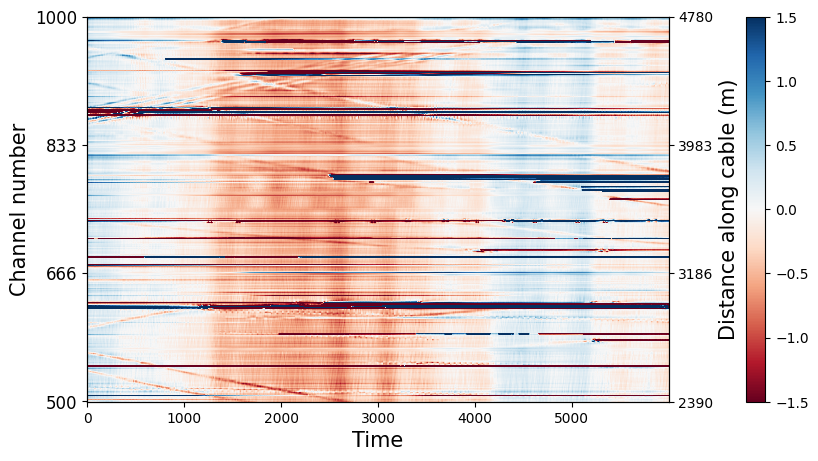

In [12]:
plt.figure(figsize = (10, 5), dpi = 100)
plt.imshow(minute_data, aspect = 'auto', 
           cmap = 'RdBu', vmax = 1.5, vmin = -1.5, origin='lower')
_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.1)

### 3.3 pre-processing

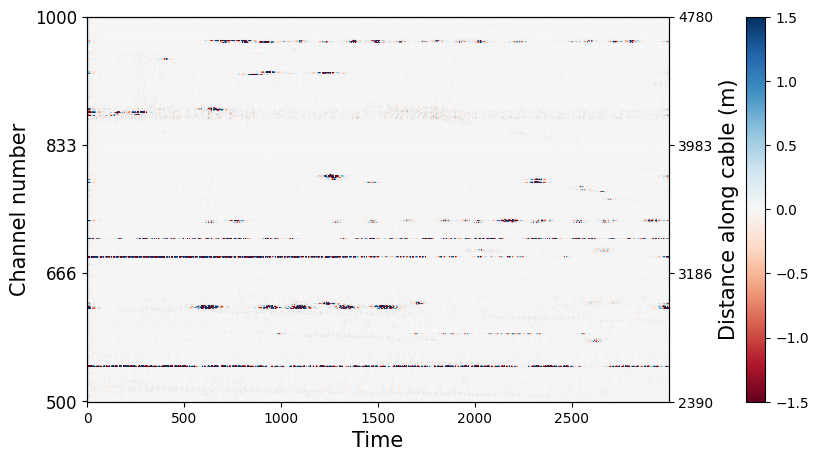

In [13]:
trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(minute_data.T, prepro_para)

plt.figure(figsize = (10, 5), dpi = 100)
plt.imshow(dataS, aspect = 'auto', 
           cmap = 'RdBu', vmax = 1.5, vmin = -1.5, origin='lower')
_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.1)

### 3.4 FFT, temporal and frequency normalizaiton (if specified)

In [14]:
white_spect = DAS_module.noise_processing(dataS, prepro_para)
Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
data = white_spect[:, :Nfft2]
# del dataS, white_spect

print(data.shape, data.dtype)

(500, 1500) complex64


### 3.5 channel-pair selection

In [15]:
ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                        (trace_stdS > 0) &
                (np.isnan(trace_stdS) == 0))[0]
if not len(ind):
    raise ValueError('the max_over_std criteria is too high which results in no data')
sta = cha_list[ind]
white_spect = data[ind]

print(white_spect.shape, white_spect.dtype)

(432, 1500) complex64


### 3.6 cross-correlate over all channel pairs

In [16]:
# loop over all stations
for iiS in range(len(sta)):
    # smooth the source spectrum
    sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)

    # correlate one source with all receivers
    corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)
    
    print(f"source channel index: {sta[iiS]}, correlation shape: {corr.shape}")

source channel index: 500, correlation shape: (432, 801)
source channel index: 501, correlation shape: (431, 801)
source channel index: 502, correlation shape: (430, 801)
source channel index: 503, correlation shape: (429, 801)
source channel index: 504, correlation shape: (428, 801)
source channel index: 505, correlation shape: (427, 801)
source channel index: 506, correlation shape: (426, 801)
source channel index: 507, correlation shape: (425, 801)
source channel index: 508, correlation shape: (424, 801)
source channel index: 509, correlation shape: (423, 801)
source channel index: 510, correlation shape: (422, 801)
source channel index: 511, correlation shape: (421, 801)
source channel index: 512, correlation shape: (420, 801)
source channel index: 513, correlation shape: (419, 801)
source channel index: 514, correlation shape: (418, 801)
source channel index: 515, correlation shape: (417, 801)
source channel index: 516, correlation shape: (416, 801)
source channel index: 517, corr

## 4 10-minute linear stacking
We create this `corr_full` and `stack_full` matrix to store a sub-stacking results. More specifically, we linearly stack each minute of correlation in memory, and only save the hourly stacking to the CCF storage (local ASDF, S3, etc.)

In [17]:
corr_full = np.zeros([n_lag, n_pair], dtype = np.float32)
stack_full = np.zeros([1, n_pair], dtype = np.int32)
task_t0 = datetime(year = 2022, month = 12, day = 1, 
                   hour = 0, minute = 0, second = 0, microsecond = 0)

n_minute = 10

We loop over all data chunk. Reminder that the data is on the cloud, and computing is made on this server. So we are downloading the data as we compute at the same time (async option?)

In [18]:
# each task is one minute
n_minute = 1
pbar = tqdm(range(n_minute))
t_query = 0; t_compute = 0
for imin in pbar:
    t0 = time.time()
    pbar.set_description(f"Processing {task_t0}")
    task_t0 += timedelta(minutes = 1)
    tdata = client.get_data(cha_list, 
            starttime = task_t0,
            endtime = task_t0 + timedelta(minutes = 1)).T
    t_query += time.time() - t0

    t1 = time.time()
    # perform pre-processing
    trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(tdata, prepro_para)

    # do normalization if needed
    white_spect = DAS_module.noise_processing(dataS, prepro_para)
    Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
    data = white_spect[:, :Nfft2]
    del dataS, white_spect

    ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                            (trace_stdS > 0) &
                    (np.isnan(trace_stdS) == 0))[0]
    if not len(ind):
        raise ValueError('the max_over_std criteria is too high which results in no data')
    sta = cha_list[ind]
    white_spect = data[ind]

    # loop over all stations
    for iiS in range(len(sta)):
        # smooth the source spectrum
        sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)
        
        # correlate one source with all receivers
        corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)

        # update the receiver list
        tsta = sta[iiS:]
        receiver_lst = tsta[tindx]

        iS = int((cha2*2 - cha1 - sta[iiS] + 1) * (sta[iiS] - cha1) / 2)

        # stacking one minute
        corr_full[:, iS + receiver_lst - sta[iiS]] += corr.T
        stack_full[:, iS + receiver_lst - sta[iiS]] += 1
        
    t_compute += time.time() - t1
corr_full /= stack_full
print("%.3f seconds in data query, %.3f seconds in xcorr computing" % (t_query, t_compute))

Processing 2022-12-01 00:00:00: 100%|██████████| 1/1 [00:09<00:00,  9.87s/it]

0.247 seconds in data query, 9.617 seconds in xcorr computing



/tmp/ipykernel_2732064/608331376.py:51: RuntimeWarning: invalid value encountered in divide
  corr_full /= stack_full


## 5 visualize and save CCF 

Text(0, 0.5, 'Distance along cable (m)')

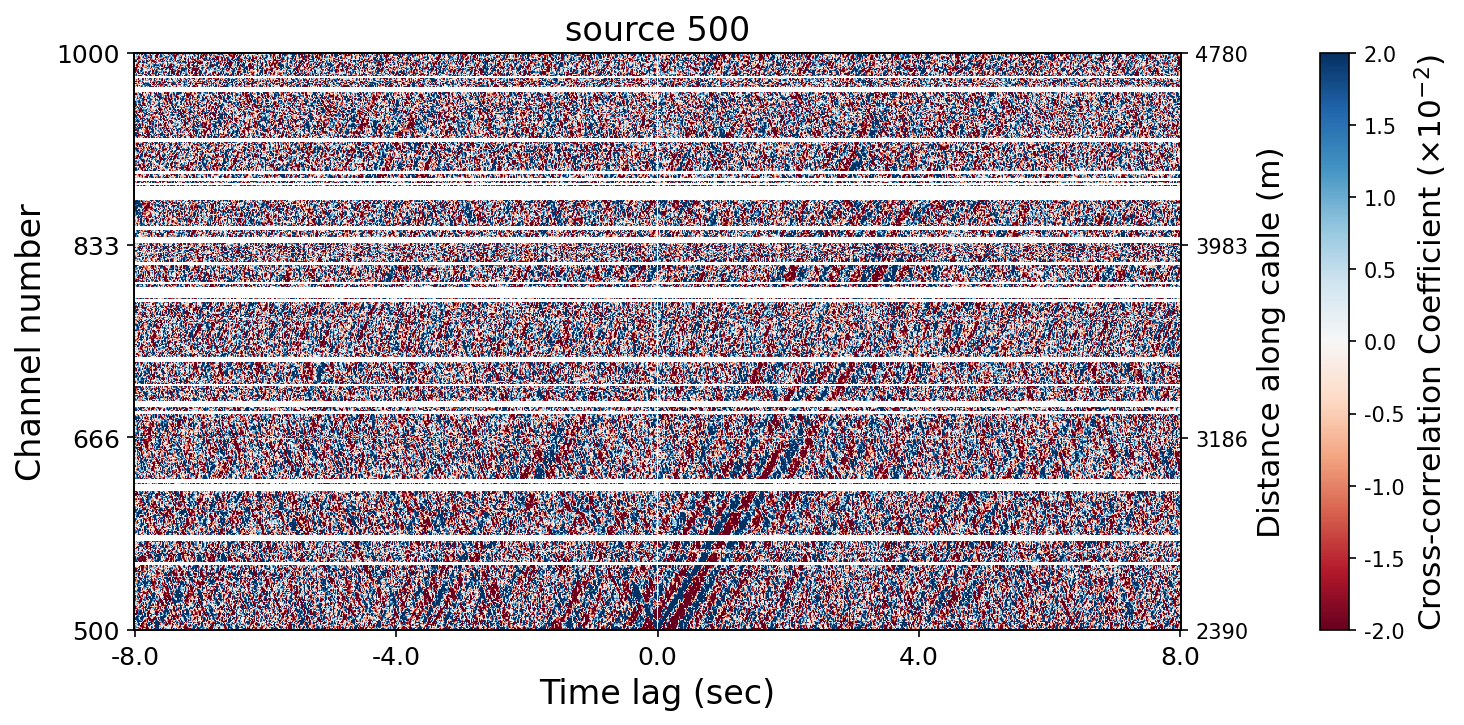

In [19]:
plt.figure(figsize = (12, 5), dpi = 150)

plt.imshow(corr_full[:, :(cha2 - cha1)].T, aspect = 'auto', cmap = 'RdBu', 
           vmax = 2e-2, vmin = -2e-2, origin = 'lower', interpolation=None)

_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
plt.ylabel("Channel number", fontsize = 16)
plt.xlabel("Time lag (sec)", fontsize = 16)
plt.title("source 500", fontsize = 16)
bar = plt.colorbar(pad = 0.1, format = lambda x, pos: '{:.1f}'.format(x*100))
bar.set_label('Cross-correlation Coefficient ($\\times10^{-2}$)', fontsize = 15)

twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)

### 5.1 ASDF (Adaptable Seismic Data Format)
The adaptable seismic data format (ASDF; Krischer et al., 2016) is one of such file formats that uses the HDF5 container to store large time series and metadata. NoisePy takes advantages of ASDF for a structured organization of the cross-correlation data while maintaining the parallel I/O capabilities (Jiang et al., 2020)

In [20]:
import pyasdf

t0 = time.time()
with pyasdf.ASDFDataSet("./CCF.h5", mpi = False) as ccf_ds:
    for iiS in tqdm(range(len(sta))):
        for iiR in range(nsta - iiS):
            # use the channel number as a way to figure out distance
            Sindx = iiS + cha1
            iS = int((cha2*2 - cha1 - Sindx + 1) * (Sindx - cha1) / 2)
            param = {'sps':samp_freq,
                    'dt': 1/samp_freq,
                    'maxlag':maxlag,
                    'freqmin':freqmin,
                    'freqmax':freqmax}

            # source-receiver pair
            data_type = str(sta[iiS])
            path = f'{Sindx}_{Sindx + iiR}'
            ccf_ds.add_auxiliary_data(data=corr_full[:, iS + iiR], 
                                      data_type=data_type, 
                                      path=path, 
                                      parameters=param)
t1 = time.time()
print(f"it takes %.3f seconds to write this ASDF file" % (t1 - t0))

  0%|          | 0/443 [00:00<?, ?it/s]

100%|██████████| 443/443 [01:43<00:00,  4.30it/s]

it takes 103.093 seconds to write this ASDF file


### 5.2 TileDB

In [21]:
import tiledb

t0 = time.time()
dim1 = tiledb.Dim(name="time_lag", domain=(0, n_lag-1), tile=n_lag, dtype=np.uint32, 
                  filters = tiledb.FilterList([tiledb.DoubleDeltaFilter(),tiledb.GzipFilter(level=-1)]))
dim2 = tiledb.Dim(name="channel_pair", domain=(0, n_pair-1), tile=100, dtype=np.uint32,
                  filters = tiledb.FilterList([tiledb.DoubleDeltaFilter(),tiledb.GzipFilter(level=-1)]))

rawdata = tiledb.Attr(name="CCF", dtype=np.float32, 
                  filters=tiledb.FilterList([tiledb.ByteShuffleFilter(), tiledb.LZ4Filter(level = 5)]),
                     fill=np.nan)

dom = tiledb.Domain(dim1, dim2)
schema = tiledb.ArraySchema(domain=dom, sparse=False, attrs=[rawdata])

tiledb.Array.create(f"./CCF.tdb", schema = schema)

with tiledb.open(f"./CCF.tdb", 'w') as A:
    A[:, :] = corr_full
    
t1 = time.time()
print(f"it takes %.3f seconds to write this TileDB file" % (t1 - t0))

it takes 0.446 seconds to write this TileDB file


In [22]:
!du -h CCF.tdb

4.0K	CCF.tdb/__schema
0	CCF.tdb/__commits
512M	CCF.tdb/__fragments/__1713384126138_1713384126138_d8f4f9050e8f40eeaafbde7d8ef9872d_16
512M	CCF.tdb/__fragments
0	CCF.tdb/__meta
0	CCF.tdb/__fragment_meta
512M	CCF.tdb


### 5.3 TileDB.S3
**There is the option to write TileDB directly to AWS S3 bucket.** So basically one can avoid writing local files (e.g., ASDF), but write from RAM to S3 directly. This is especially efficient when running xcorr jobs on AWS in a way that you don't need to have much local storage for the instance running sub-tasks (e.g., EBS).

In [23]:
# create a configuration object
config = tiledb.Config()

# set configuration parameters
config["vfs.s3.scheme"] = "https"
config["vfs.s3.region"] = "us-west-2"
config["vfs.s3.endpoint_override"] = ""
config["vfs.s3.use_virtual_addressing"] = "true"
config["vfs.s3.aws_access_key_id"] = "YOUR_AWS_ACCESS_KEY"
config["vfs.s3.aws_secret_access_key"] =  "YOUR_AWS_SECRET_ACCESS_KEY"
    
# create contex
ctx = tiledb.Ctx(config)

bucket = "s3://seisscoped-hps"

with tiledb.open(f"./CCF.tdb", 'w', ctx = ctx) as A:
    A[:, :] = corr_full

# EOF

In [24]:
def correlate(fft1_smoothed_abs,fft2,D,Nfft):
    import scipy
    #----load paramters----
    sps     = D['samp_freq']
    dt      = 1/sps
    maxlag  = D['maxlag']
    method  = D['cc_method']
    smoothspect_N = D['smoothspect_N']

    nwin  = fft2.shape[0]
    Nfft2 = fft2.shape[1]

    #------convert all 2D arrays into 1D to speed up--------
    corr = np.zeros(nwin*Nfft2,dtype=np.complex64)
    fft1 = np.repeat(fft1_smoothed_abs.reshape(1,fft1_smoothed_abs.size), nwin, axis = 0)  # duplicate fft1_smoothed_abs for nwin rows
    corr = fft1.reshape(fft1.size,)*fft2.reshape(fft2.size,)

    corr  = corr.reshape(nwin,Nfft2)

    # loop through each cross correlation
    ampmax = np.zeros(nwin,dtype=np.float32)

    crap   = np.zeros(shape=(nwin, Nfft), dtype=np.complex64)
    crap[:, :Nfft2] = corr
    crap[:, :Nfft2] -= np.mean(crap[:, :Nfft2], axis=-1, keepdims=True)
    crap[:, -(Nfft2)+1:] = np.flip(np.conj(crap[:, 1:(Nfft2)]), axis=-1)
    # crap[:, 0] = complex(0,0)
    s_corr = scipy.fftpack.ifftshift(scipy.fftpack.ifft(crap, Nfft, axis = -1), axes = -1).real

    # remove abnormal trace
    ampmax = np.max(s_corr,axis=1)
    tindx  = np.where( (ampmax<20*np.median(ampmax)) & (ampmax>0))[0]
    s_corr = s_corr[tindx,:]

    t = np.arange(-Nfft2,Nfft2)*dt
    ind = np.where(np.abs(t) <= maxlag)[0]
    if s_corr.ndim==1:
        s_corr = s_corr[ind]
    elif s_corr.ndim==2:
        s_corr = s_corr[:,ind]
    return s_corr,tindx

Text(0, 0.5, 'Distance along cable (m)')

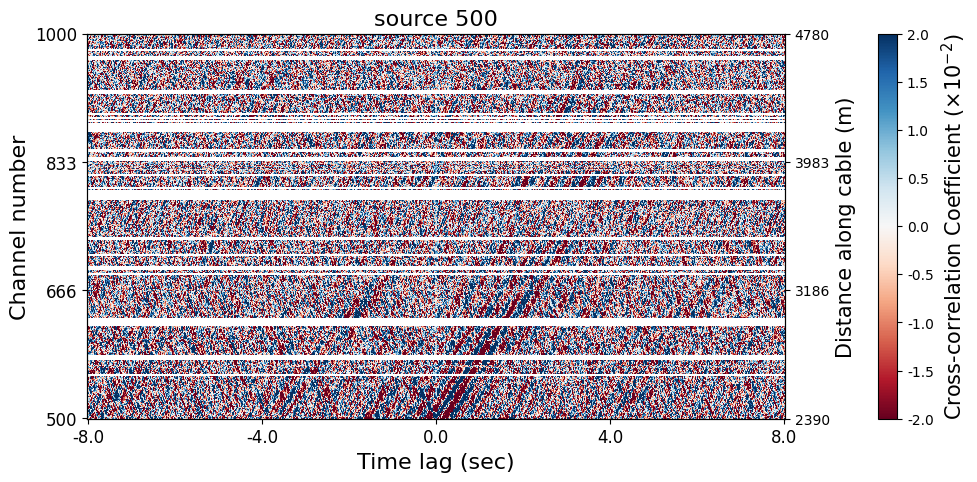

In [25]:
plt.figure(figsize = (12, 5), dpi = 100)

plt.imshow(corr_full[:, :(cha2 - cha1)].T, aspect = 'auto', cmap = 'RdBu', 
           vmax = 2e-2, vmin = -2e-2, origin = 'lower', interpolation=None)

_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
plt.ylabel("Channel number", fontsize = 16)
plt.xlabel("Time lag (sec)", fontsize = 16)
plt.title("source 500", fontsize = 16)
bar = plt.colorbar(pad = 0.1, format = lambda x, pos: '{:.1f}'.format(x*100))
bar.set_label('Cross-correlation Coefficient ($\\times10^{-2}$)', fontsize = 15)

twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)